# Initial state estimation with Minor Planet Center Observations
Copyright (c) 2010-2023, Delft University of Technology. All rights reserved. This file is part of the Tudat. Redistribution and use in source and binary forms, with or without modification, are permitted exclusively under the terms of the Modified BSD license. You should have received a copy of the license with this file. If not, please or visit: http://tudat.tudelft.nl/LICENSE.

## Context
This example highlights a simple orbit estimation routine using real, angular observation data from the  [Minor Planet Center](https://www.minorplanetcenter.net/) (MPC). We will estimate the initial state of [Eros](https://en.wikipedia.org/wiki/433_Eros) a near-Earth asteroid visited by the NEAR Shoemaker probe in 1998. We will use the Tudat BatchMPC interface to retrieve and process the data. For a more in depth explanation of this interface we recommend first checking out the [Retrieving observation data from the Minor Planet Centre](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/retrieving_mpc_observation_data.html) example. We will also briefly use the SBDBquery class which interfaces JPL's [Small Body DataBase (SBDB)](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html).

## Import statements

In [2]:
# Tudat imports for propagation and estimation
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation

# import MPC interface
from tudatpy.data.mpc import BatchMPC

# import SBDB interface
from tudatpy.data.sbdb import SBDBquery

# other useful modules
import numpy as np
import datetime

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

## Preparing the environment and observations

### Loading Spice Kernels.
We use SPICE kernels to retrieve the ephemerides the planets as well as to verify our results for Eros. The ephemerides for Eros and other asteroids are loaded in with the `codes_300ast_20100725.bsp` kernel included with Tudat's standard kernels.

In [3]:
# SPICE KERNELS
spice.load_standard_kernels()

### Setting some constants
Let's setup some constants that are used throughout the tutorial. The MPC code for Eros is 433. We also set a start and end date for our observations, the number of iterations for our estimation, a timestep for our integrator and a 1 month buffer to avoid interpolation errors in our analysis.

We use a spice kernel to get a guess for our initial state and to check our estimation afterwards. The default spice kernel `codes_300ast_20100725.bsp` contains many popular asteroids, however they are not all identified by name (433 Eros is `"Eros"` but 16 Psyche is `"2000016"` etc.). To ensure this example works dynamically, for any single MPC code as input we use the SDBD to retrieve the name and SPK-ID used for the spice kernel.

For our frame origin we use the Solar System Barycentre. The data from MPC is presented in the J2000 reference frame, currently BatchMPC does not support conversion to other reference frames and as such we match it in our environment. 

Direct inputs:

In [4]:
target_mpc_code = 433

observations_start = datetime.datetime(2018, 1, 1)
observations_end = datetime.datetime(2023, 7, 1)

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 20 hours for our estimation
timestep_global = 20 * 3600

# 1 month time buffer used to avoid interpolation errors:
time_buffer = 1 * 31 * 86400

# define the frame origin and orientation.
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

Derived inputs:

In [5]:
target_sbdb = SBDBquery(target_mpc_code)

mpc_codes = [target_mpc_code]  # the BatchMPC interface requires a list.
target_spkid = target_sbdb.codes_300_spkid  # the ID used by the
target_name = target_sbdb.shortname  # the ID used by the

print(f"SPK ID for {target_name} is: {target_spkid}")

SPK ID for 433 Eros is: Eros


### Retrieving the observations
We retrieve the observation data using the BatchMPC interface. By default all observation data is retrieved, even the first observations from Witt in 1898. We filter to only include data between our start and end dates.

In [6]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
)

batch.summary()


   Batch Summary:
1. Batch includes 1 minor planets:
   ['433']
2. Batch includes 3095 observations, including 1733 observations from space telescopes
3. The observations range from 2018-05-01 03:22:18.336012 to 2023-06-27 00:37:43.680017
   In seconds TDB since J2000: 578417007.5214744 to 741098332.8642726
   In Julian Days: 2458239.64049 to 2460122.5262
4. The batch contains observations from 53 observatories, including 3 space telescopes



Our batch includes many observations from space telescopes, lets take a closer look at that data.

In [7]:
print("Summary of space telescopes in batch:")
print(batch.observatories_table(only_space_telescopes=True))
obs_by_WISE = (
    batch.table.query("observatory == 'C51'")
    .loc[:, ["number", "epochUTC", "RA", "DEC"]]
    .iloc[[0, -1]]
)

print("\nInitial and Final Observations by WISE:")
print(obs_by_WISE)

Summary of space telescopes in batch:
     Code        Name   count
1225  C51        WISE   111.0
1231  C57        TESS  1620.0
1232  C59  Yangwang-1     2.0

Initial and Final Observations by WISE:
      number                   epochUTC        RA       DEC
10523    433 2018-07-25 00:09:44.063981  0.468337  0.388395
13536    433 2023-05-15 12:31:37.344004  5.690128 -0.311711


While the observations from WISE appear to be useful, including them requires setting up the dynamics for the WISE spacecraft which is too advanced for this tutorial and its observations will be excluded later on in this example. The observations can also be filtered out explicitly by excluding the observatories with the .filter() method, specifying their codes (C57 etc.). Note that all the observations are given in an angular format, Right Ascension (RA) and Declination (DEC) in radians.

### Set up the environment
We now set up the environment, including the bodies to use, the reference frame and frame origin. The epherides for all major planets as well as the Earth's Moon are retrieved using spice. 

BatchMPC will automatically generate the body object for Eros, but we still need to specify the bodies to propagate and their central bodies. We can retrieve the list from the BatchMPC object.

In [8]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Mercury",
    "Venus",
    "Earth",
    "Moon",
    "Mars",
    "Jupiter",
    "Saturn",
    "Uranus",
    "Neptune",
]

# Create system of bodies
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin]

### Convert the observations to Tudat
Now that our system of bodies is ready we can retrieve the observation collection from the observations batch using the `to_tudat()` method. Note that by setting the included_satellites to `None`, space telescope observations are filtered out. From the observation collection we can also retrieve observation links. We use the links to define our observations settings this is where you would also add bias settings. For the purpose of this example, we will keep it simple and use the plain angular position settings, which can process observations with Right Ascension and Declination. We can also retrieve the times for the first and final observations from the batch object in seconds since J2000 TDB, which is what tudat uses internally. We here add our buffer, set previously, to avoid interpolation errors down the line.

In [9]:
# Transform the MPC observations into a tudat compatible format.
# note that we explicitly exlude all satellite observations in this step by setting included satellites to None.
observation_collection = batch.to_tudat(bodies=bodies, included_satellites=None)

# set create angular_position settings for each link in the list.
observation_settings_list = list()
link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings here
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )
# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch.epoch_start
epoch_end_nobuffer = batch.epoch_end

epoch_start_buffer = epoch_start_nobuffer - time_buffer
epoch_end_buffer = epoch_end_nobuffer + time_buffer

### Creating the acceleration settings
Eros will be propagated and as such we need to define the settings of the forces acting on it. We will include point mass gravity accelerations for each of the bodies defined before, as well as Schwarzschild relativistic corrections for the Sun. With these accelerations we can generate our acceleration model for the propagation. A more realistic acceleration model will yield better results but this is outside the scope of this example. 

In [10]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only Eros
acceleration_settings = {}
for body in batch.MPC_objects:
    acceleration_settings[str(body)] = accelerations

# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)

### Retrieving an initial guess for Eros' position
We use the SPICE ephemeris to retrieve a 'benchmark' initial state for Eros at the first epoch. We can also use this initial state as our initial guess for the estimation. We add a random uniform offset of +/- 1 million kilometers for the position and 100 m/s for the velocity. Adding this random offset should not have a strong influence on the final results, it is added in to keep the tutorial representative. In real-world cases we might not have such a good initial guess.

In [11]:
# benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    target_spkid,
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e6 * 1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

Error between the real initial state and our initial guess:
[ 8.67054018e+08  1.04436121e+08  6.08103526e+07  1.62748932e+01
 -1.78045513e+01  3.71089295e+01]


### Finalising the propagation setup
For the integrator we use the fixed timestep RKF-7(8) setting our initial time to the time of the batch's final observation - buffer. We then set the termination to stop at the time of the batch's oldest observation plus buffer. These two settings are then the final pieces to create our propagation settings. 

In [12]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)


# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

## Setting Up the estimation
With the observation collection, the environment and propagations settings ready we can now begin setting up our estimation. 

In this example we will simply estimate the position of Eros and as such only include an initial states parameter.

In [13]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

The `Estimator` object collects the environment, observation settings and propagation settings. We also create an `EstimationInput` object and provide it our observation collection retrieved from `.to_tudat()`. Our maximum iterations steps was previously set to 6.

In [14]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)

## Performing the estimation

With everything set up we can now perform the estimation. 

In [15]:
# Perform the estimation
pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 2724
Current residual: 0.0651006
Parameter update -1.1154e+09 -3.74729e+08  1.45194e+08     -13.3965      29.5008      -46.729
Calculating residuals and partials 2724
Current residual: 0.00715581
Parameter update  2.4508e+08  2.66846e+08 -2.02303e+08     -2.67251     -11.5244      9.24734
Calculating residuals and partials 2724
Current residual: 4.44001e-05
Parameter update  3.1942e+06  3.43325e+06 -3.74877e+06     -0.20159    -0.176217     0.373858
Calculating residuals and partials 2724
Current residual: 1.7896e-06
Parameter update   -159.263     92.6263     20.9602 8.31021e-06  -1.414e-05 1.27868e-05
Calculating residuals and partials 2724
Current residual: 1.78958e-06
Parameter update   0.0013206  0.000991714  0.000487634 -8.67286e-11 -6.18817e-11 -3.71523e-11
Calculating residuals and partials 2724
Current residual: 1.78958e-06
Maximum number of iterations reached
Parameter update -0.00492639  -0.00117797   -0.0013421   3.7442e-10 -2.28395e-10 -8

The estimator appears to converge within ~4 steps. Lets check how close our initial guess and final estimate are compared to the benchmark initial state.

In [16]:
# retrieve the estimated initial state.
results_final = pod_output.parameter_history[:, -1]

vector_error_initial = (np.array(initial_guess) - initial_states)[0:3]
error_magnitude_initial = np.sqrt(np.square(vector_error_initial).sum()) / 1000

vector_error_final = (np.array(results_final) - initial_states)[0:3]
error_magnitude_final = np.sqrt(np.square(vector_error_final).sum()) / 1000

print(
    f"{target_name} initial guess radial error to spice: {round(error_magnitude_initial, 2)} km"
)
print(
    f"{target_name} final radial error to spice: {round(error_magnitude_final, 2)} km"
)

433 Eros initial guess radial error to spice: 875435.59 km
433 Eros final radial error to spice: 83.92 km


## Visualising the results

#### Change in residuals per iteration
We want to visualise the residuals, splitting them between Right Ascension and Declination. Internally, `concatentated_observations` orders the observations alternating RA, DEC, RA, DEC,... This allows us to map the colors accordingly by taking every other item in the `residual_history`/`concatentated_observations`, i.e. by slicing [::2].

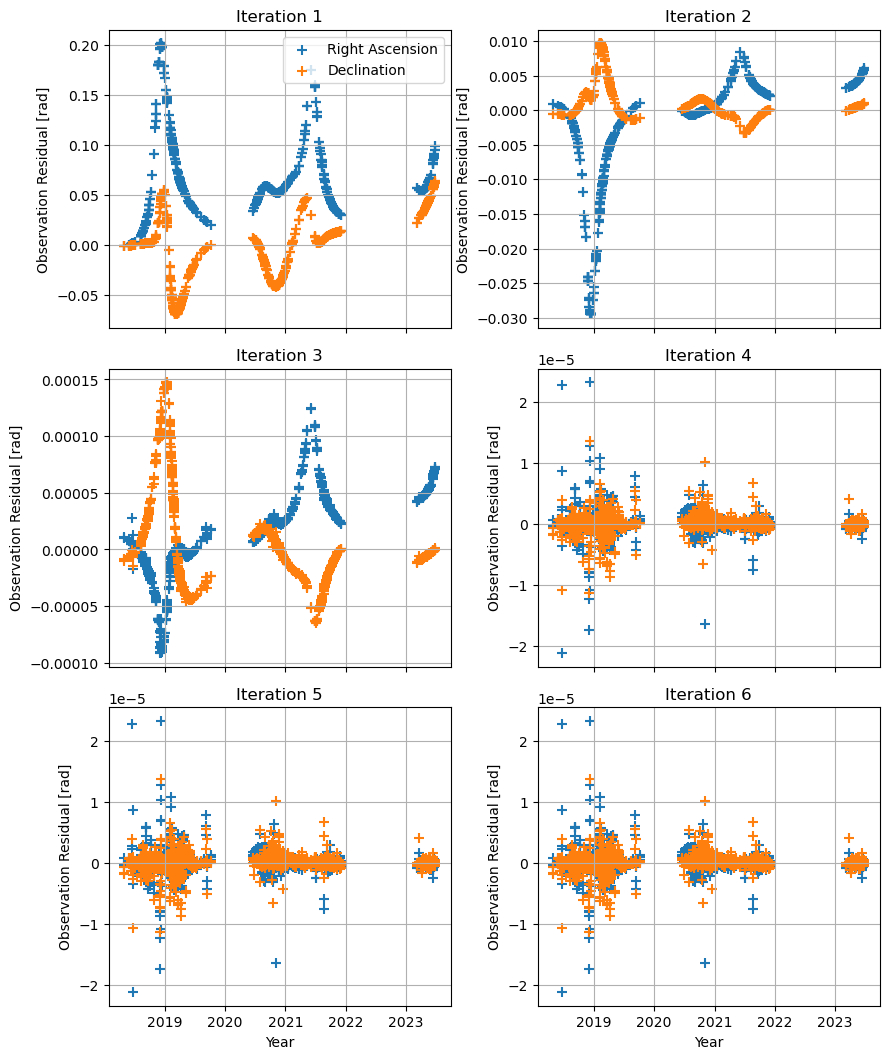

In [17]:
residual_history = pod_output.residual_history

# Number of columns and rows for our plot
number_of_columns = 2

number_of_rows = (
    int(number_of_pod_iterations / number_of_columns)
    if number_of_pod_iterations % number_of_columns == 0
    else int((number_of_pod_iterations + 1) / number_of_columns)
)

fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(9, 3.5 * number_of_rows),
    sharex=True,
    sharey=False,
)

# We cheat a little to get an approximate year out of our times (which are in seconds since J2000)
residual_times = (
    np.array(observation_collection.concatenated_times) / (86400 * 365.25) + 2000
)


# plot the residuals, split between RA and DEC types
for idx, ax in enumerate(fig.get_axes()):
    ax.grid()
    # we take every second
    ax.scatter(
        residual_times[::2],
        residual_history[
            ::2,
            idx,
        ],
        marker="+",
        s=60,
        label="Right Ascension",
    )
    ax.scatter(
        residual_times[1::2],
        residual_history[
            1::2,
            idx,
        ],
        marker="+",
        s=60,
        label="Declination",
    )
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_title("Iteration " + str(idx + 1))

plt.tight_layout()

# add the year label for the x-axis
for col in range(number_of_columns):
    axs[int(number_of_rows - 1), col].set_xlabel("Year")

axs[0, 0].legend()

plt.show()

As seen previously, the estimation converges around iteration 4.

#### Residuals Corellations Matrix
Lets check out the corellation of the estimated parameters.

Calculating residuals and partials 2724


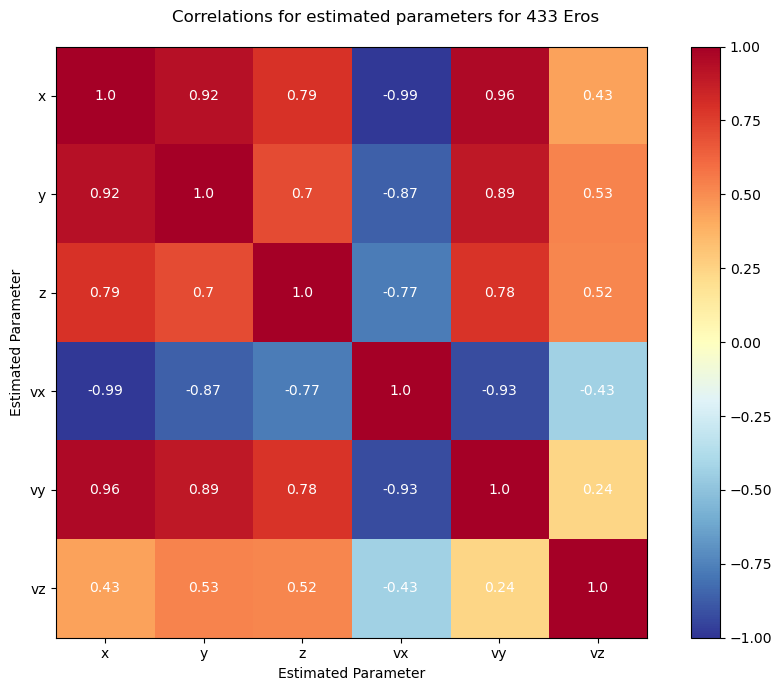

In [18]:
# Corellation can be retrieved using the CovarianceAnalysisInput class:
covariance_input = estimation.CovarianceAnalysisInput(observation_collection)
covariance_output = estimator.compute_covariance(covariance_input)

correlations = covariance_output.correlations
estimated_param_names = ["x", "y", "z", "vx", "vy", "vz"]


fig, ax = plt.subplots(1, 1, figsize=(9, 7))

im = ax.imshow(correlations, cmap=cm.RdYlBu_r, vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)
ax.set_yticks(np.arange(len(estimated_param_names)), labels=estimated_param_names)

# add numbers to each of the boxes
for i in range(len(estimated_param_names)):
    for j in range(len(estimated_param_names)):
        text = ax.text(
            j, i, round(correlations[i, j], 2), ha="center", va="center", color="w"
        )

cb = plt.colorbar(im)

ax.set_xlabel("Estimated Parameter")
ax.set_ylabel("Estimated Parameter")

fig.suptitle(f"Correlations for estimated parameters for {target_name}")

fig.set_tight_layout(True)

#### Orbit error vs spice over time
Next, lets take a look at the error of the orbit over time, using spice as a reference.

We saw in the residuals graph that there are two large gaps in observations, for 2022 and around Jan 2020. Lets collect those gaps and overlay them on to our error plot.

In [19]:
# lets get ranges for all gaps larger than 6 months:
gap_in_months = 6

gaps = np.abs(np.diff(sorted(residual_times)))
num_gaps = (
    gaps > (gap_in_months / 12)
).sum()  # counts the number of gaps larger than 0.5 years
indices_of_largest_gaps = np.argsort(gaps)[-num_gaps:]

# (start, end) for each of the gaps
gap_ranges = [
    (sorted(residual_times)[idx - 1], sorted(residual_times)[idx + 1])
    for idx in indices_of_largest_gaps
]

print(f"Largest gap = {round(max(gaps), 3)} years")
print(gap_ranges)

Largest gap = 1.263 years
[(2019.7692566946516, 2020.46532939287), (2021.9181437117866, 2023.1810429863324)]


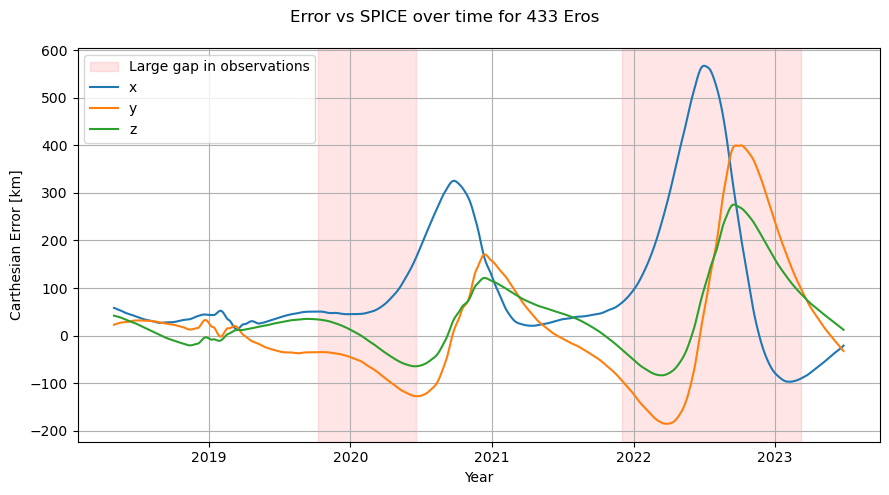

In [20]:
# Now lets plot the orbit error
fig, ax = plt.subplots(1, 1, figsize=(9, 5))

# show areas where there are no observations:
for i, gap in enumerate(gap_ranges):
    ax.axvspan(
        xmin=gap[0],
        xmax=gap[1],
        color="red",
        alpha=0.1,
        label="Large gap in observations" if i == 0 else None,
    )

spice_states = []
estimation_states = []

# retrieve the states for a list of times.
times = np.linspace(epoch_start_nobuffer, epoch_end_nobuffer, 1000)
times_plot = times / (86400 * 365.25) + 2000  # approximate
for time in times:
    # from spice
    state_spice = spice.get_body_cartesian_state_at_epoch(
        target_spkid, central_bodies[0], global_frame_orientation, "NONE", time
    )
    spice_states.append(state_spice)

    # from estimation
    state_est = bodies.get(str(target_mpc_code)).ephemeris.cartesian_state(time)
    estimation_states.append(state_est)

# Error in kilometers
error = (np.array(spice_states) - np.array(estimation_states)) / 1000

# plot
ax.plot(times_plot, error[:, 0], label="x")
ax.plot(times_plot, error[:, 1], label="y")
ax.plot(times_plot, error[:, 2], label="z")

ax.grid()
ax.legend(ncol=1)

plt.tight_layout()

ax.set_ylabel("Carthesian Error [km]")
ax.set_xlabel("Year")

fig.suptitle(f"Error vs SPICE over time for {target_name}")
fig.set_tight_layout(True)

plt.show()

Please note that a lack of observations in an area of time does not necessarily result in a bad fit in that area. Lets look at the observatories next.

#### Final residuals highlighted per observatory
This plot shows the final iteration of the residuals, highlighting the 10 observatories with the most observations.

In [21]:
# 10 observatories with most observations
num_observatories = 10

finalresiduals = np.array(residual_history[:, -1])
# if you would like to check the iteration 1 residuals, use:
# finalresiduals = np.array(residual_history[:, 0])

In [22]:
# This piece of code collects the 10 largest observatories
observatory_names = (
    batch.observatories_table(exclude_space_telescopes=True)
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
    .set_index("Code")
)
top_observatories = observatory_names.index.tolist()

# This piece of code creates a `concatenated_receiving_observatories` map
# to identify the observatories by their MPC code instead of an internally used id
residuals_observatories = observation_collection.concatenated_link_definition_ids
unique_observatories = set(residuals_observatories)

observatory_link_to_mpccode = {
    idx: observation_collection.link_definition_ids[idx][
        observation.LinkEndType.receiver
    ].reference_point
    for idx in unique_observatories
}

# the resulting map (MPC code for each item in the residuals_history):
concatenated_receiving_observatories = np.array(
    [observatory_link_to_mpccode[idx] for idx in residuals_observatories]
)

# mask for the observatories not in top 10:
mask_not_top = [
    (False if observatory in top_observatories else True)
    for observatory in concatenated_receiving_observatories
]

# get the number of observations by the other observatories
# (divide by two because the observations are concatenated RA,DEC in this list)
n_obs_not_top = int(sum(mask_not_top) / 2)

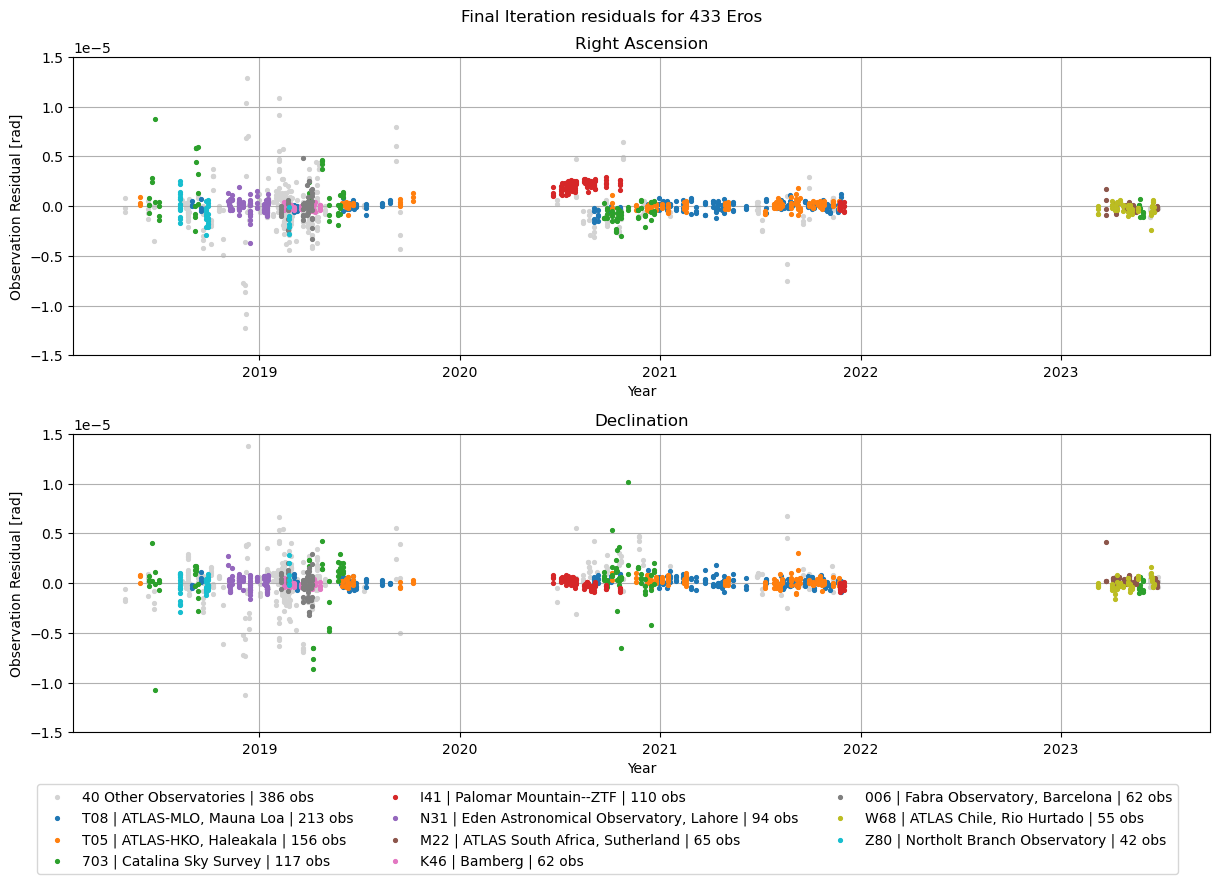

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(13, 9))

# Plot remaining observatories first
# RA
axs[0].scatter(
    residual_times[mask_not_top][::2],
    finalresiduals[mask_not_top][::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | {n_obs_not_top} obs",
    color="lightgrey",
)
# DEC
axs[1].scatter(
    residual_times[mask_not_top][1::2],
    finalresiduals[mask_not_top][1::2],
    marker=".",
    s=30,
    label=f"{len(unique_observatories) - num_observatories} Other Observatories | {n_obs_not_top} obs",
    color="lightgrey",
)

# plots the highlighted top 10 observatories
for observatory in top_observatories:
    name = f"{observatory} | {observatory_names.loc[observatory].Name} | {int(observatory_names.loc[observatory]['count'])} obs"
    axs[0].scatter(
        residual_times[concatenated_receiving_observatories == observatory][::2],
        finalresiduals[concatenated_receiving_observatories == observatory][::2],
        marker=".",
        s=30,
        label=name,
        zorder=100,
    )
    axs[1].scatter(
        residual_times[concatenated_receiving_observatories == observatory][1::2],
        finalresiduals[concatenated_receiving_observatories == observatory][1::2],
        marker=".",
        s=30,
        label=name,
        zorder=100,
    )


axs[1].legend(ncols=3, loc="upper center", bbox_to_anchor=(0.47, -0.15))

for ax in fig.get_axes():
    ax.grid()
    ax.set_ylabel("Observation Residual [rad]")
    ax.set_xlabel("Year")
    # this step hides a few outliers (~3 observations)
    ax.set_ylim(-1.5e-5, 1.5e-5)

axs[0].set_title("Right Ascension")
axs[1].set_title("Declination")

fig.suptitle(f"Final Iteration residuals for {target_name}")
fig.set_tight_layout(True)

plt.show()

#### Residual Boxplots per observatory
Let's visualise these residuals as boxplots as well, again splitting for right ascension and declination. Note that some low level Matplotlib is used for this plot. Consider using the simplified [seaborn boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) implementation if this format is relevant to your use case.

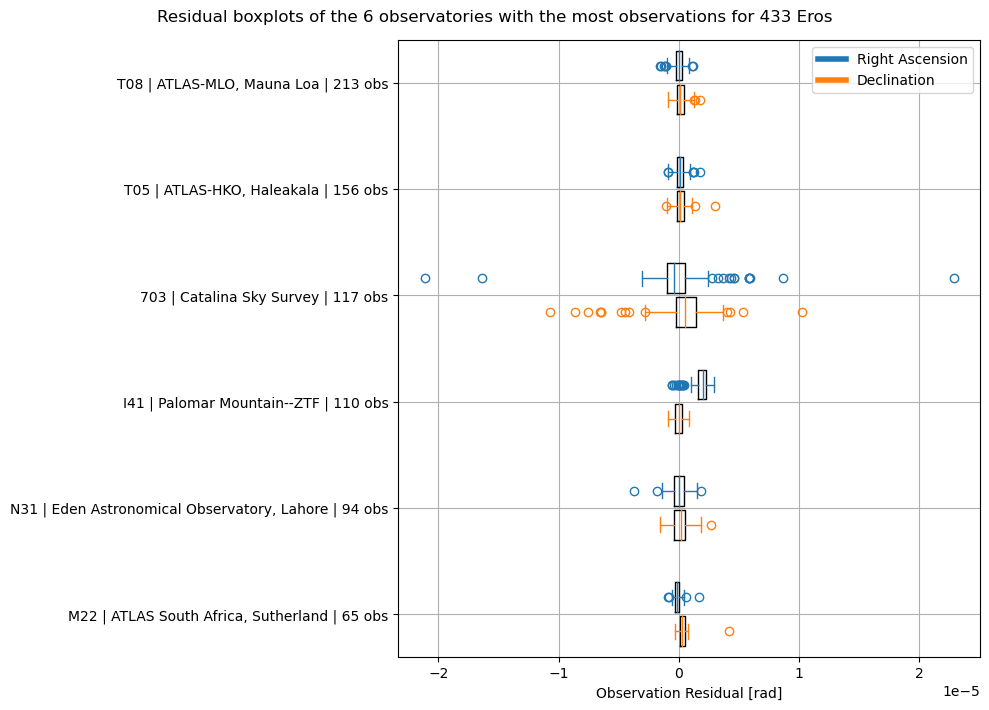

In [24]:
num_observatories = 6

data_per_observatory_list_RA = []
data_per_observatory_list_DEC = []
names = []

fig, ax = plt.subplots(1, 1, figsize=(10, 1.2 * num_observatories))

# we retrieve the observatory names again
observatory_names_box = (
    batch.observatories_table(exclude_space_telescopes=True)
    .set_index("Code")
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
)

top_observatories_box = observatory_names_box.index.tolist()

# retrieve the data for RA and DEC seperately
for observatory in top_observatories_box[::-1]:
    name = f"{observatory} | {observatory_names_box.loc[observatory].Name} | {int(observatory_names_box.loc[observatory]['count'])} obs"
    names.append(name)
    data_per_observatory_list_RA.append(
        finalresiduals[concatenated_receiving_observatories == observatory][::2]
    )

    data_per_observatory_list_DEC.append(
        finalresiduals[concatenated_receiving_observatories == observatory][1::2]
    )

# positioning the boxes
pos = (np.arange(0, len(top_observatories_box)) + 1) * 10
widths = 2.8
offset = 1.6

# box colors
RA_color = "tab:blue"
DEC_color = "tab:orange"

# boxes for RA and DEC
RAplots = ax.boxplot(
    x=data_per_observatory_list_RA,
    vert=False,
    positions=pos + offset,
    widths=widths,
    patch_artist=False,
    capprops=dict(color=RA_color),
    whiskerprops=dict(color=RA_color),
    flierprops=dict(color=RA_color, markeredgecolor=RA_color),
    medianprops=dict(color=RA_color),
)
DECplots = ax.boxplot(
    x=data_per_observatory_list_DEC,
    vert=False,
    positions=pos - offset,
    widths=widths,
    patch_artist=False,
    capprops=dict(color=DEC_color),
    whiskerprops=dict(color=DEC_color),
    flierprops=dict(color=DEC_color, markeredgecolor=DEC_color),
    medianprops=dict(color=DEC_color),
)
# custom ticks
ax.set_yticks(ticks=pos, labels=names)

# custom legend
place_holder_lines = [
    Line2D([0], [0], color=RA_color, lw=4),
    Line2D([0], [0], color=DEC_color, lw=4),
]
ax.legend(place_holder_lines, ["Right Ascension", "Declination"])

ax.grid()
ax.set_xlabel("Observation Residual [rad]")

fig.suptitle(
    f"Residual boxplots of the {num_observatories} observatories with the most observations for {target_name}"
)

# reducing whitespace
ax.set_ylim(10 - 4, int(len(top_observatories_box) * 10) + 4)

fig.set_tight_layout(True)
plt.show()

#### Histograms per observatory
Finally, lets get the residual histogram for the top 6 observatories, splitting again for right ascension and declination.

In [25]:
num_observatories = 6
nbins = 20
number_of_columns = 2
transparency = 0.6

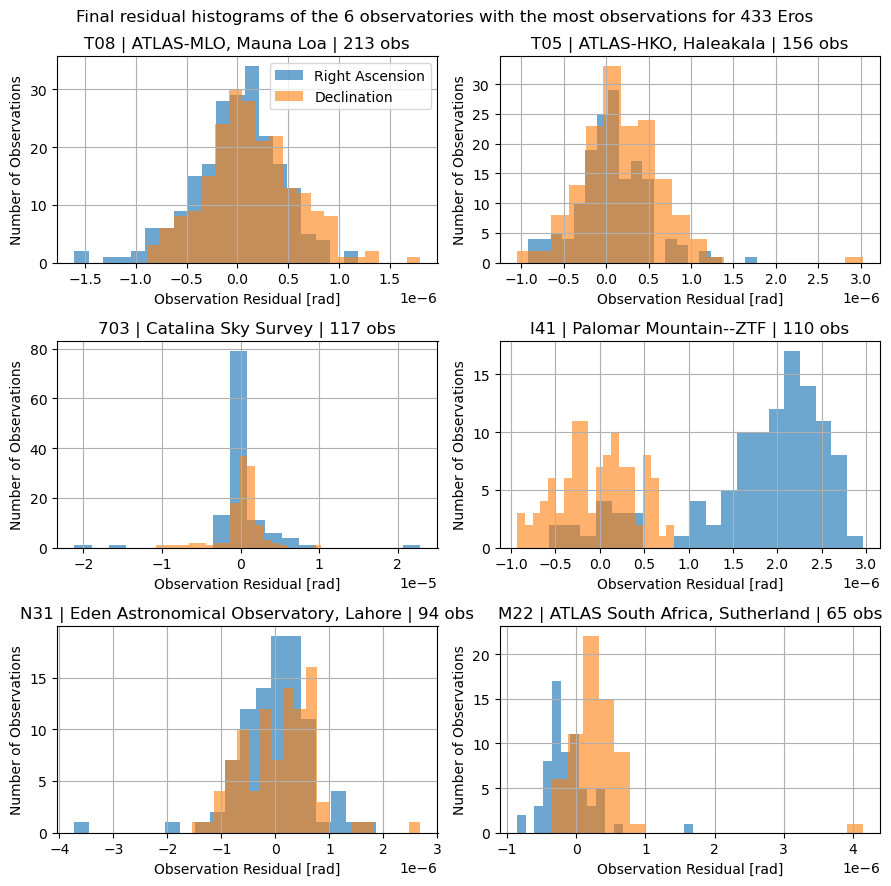

In [26]:
number_of_rows = (
    int(num_observatories / number_of_columns)
    if num_observatories % number_of_columns == 0
    else int((num_observatories + 1) / number_of_columns)
)

# we retrieve the observatory names again
observatory_names_hist = (
    batch.observatories_table(exclude_space_telescopes=True)
    .set_index("Code")
    .sort_values("count", ascending=False)
    .iloc[0:num_observatories]
)

top_observatories_hist = observatory_names_hist.index.tolist()


fig, axs = plt.subplots(
    number_of_rows,
    number_of_columns,
    figsize=(4.5 * number_of_columns, 3 * number_of_rows),
)

axs = axs.flatten()

for idx, observatory in enumerate(top_observatories_hist):
    name = f"{observatory} | {observatory_names_hist.loc[observatory].Name} | {int(observatory_names_hist.loc[observatory]['count'])} obs"

    axs[idx].hist(
        finalresiduals[concatenated_receiving_observatories == observatory][0::2],
        bins=nbins,
        alpha=transparency + 0.05,
        label="Right Ascension",
    )
    axs[idx].hist(
        finalresiduals[concatenated_receiving_observatories == observatory][1::2],
        bins=nbins,
        alpha=transparency,
        label="Declination",
    )

    axs[idx].grid()
    axs[idx].set_title(name)
    axs[idx].set_ylabel("Number of Observations")
    axs[idx].set_xlabel("Observation Residual [rad]")

axs[0].legend()

fig.suptitle(
    f"Final residual histograms of the {num_observatories} observatories with the most observations for {target_name}"
)
fig.set_tight_layout(True)
plt.show()

That's it for this tutorial! The final estimation result is quite close to spice at times, but there is clearly plenty of room for improvement in both the dynamical model and the estimation settings. Consider for example adding weights and biases on observations and links as well as improved integrator settings and perturbations. 

Consider rerunning the script for some other object by changing the `target_mpc_code` variable and seeing how the results change.